In [107]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models as tfk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import metrics
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [108]:
# Load Data
data = np.load('/kaggle/input/homwwork2n/mars_for_students.npz')

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Add a color channel and rescale pixel values to be between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
y_train = y_train[..., np.newaxis]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128, 1)
Training y shape: (2615, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


In [109]:
# Check the number of samples for each class
y_train_flat = y_train.flatten()

# Get all unique classes and their corresponding pixel counts
unique_classes, class_counts = np.unique(y_train_flat, return_counts=True)

# Total number of pixels
total_pixels = len(y_train_flat)

# Calculate the weight for each class
num_classes = len(unique_classes)
class_weights = {}
for cls, count in zip(unique_classes, class_counts):
    class_weights[cls] = total_pixels / (num_classes * count)

print("Class Weights:", class_weights)

# Print the number of pixels for each class
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} pixels")


Class Weights: {0.0: 0.7837031904451639, 1.0: 0.600805652073069, 2.0: 0.8808547820383928, 3.0: 1.0892999384976494, 4.0: 158.89982568705264}
Class 0.0: 5466886 pixels
Class 1.0: 7131118 pixels
Class 2.0: 4863930 pixels
Class 3.0: 3933183 pixels
Class 4.0: 26963 pixels


In [110]:
# Create augmented dataset for class 4.0
class_4_indices = [i for i in range(len(y_train)) if np.any(y_train[i] == 4)]

X_class_4 = X_train[class_4_indices]
y_class_4 = y_train[class_4_indices]

print("X_class_4 shape:", X_class_4.shape)
print("y_class_4 shape:", y_class_4.shape)

X_class_4 shape: (63, 64, 128, 1)
y_class_4 shape: (63, 64, 128, 1)


In [111]:
# Data augmentation for minority class (Class 4.0)
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [112]:
# Data augmentation
augmented_images = []
augmented_labels = []

batch_size = 32  # Use a smaller batch size.

for _ in range(10):  # Perform augmentation 10 times to increase the dataset
    for X_batch, y_batch in datagen.flow(X_class_4, y_class_4, batch_size=batch_size, shuffle=False):
        augmented_images.append(X_batch)
        augmented_labels.append(y_batch)

        # Stop augmentation to prevent excessive samples (avoid memory issues).
        if len(augmented_images) * batch_size >= len(X_class_4):
            break

# Concatenate augmented data
X_augmented = np.concatenate(augmented_images, axis=0)
y_augmented = np.concatenate(augmented_labels, axis=0)

# Print final shapes to verify
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Add augmented data to the training set
X_train = np.concatenate((X_train, X_augmented), axis=0)
y_train = np.concatenate((y_train, y_augmented), axis=0)

# Print final shapes to verify
print("Final X_train shape:", X_train.shape)
print("Final y_train shape:", y_train.shape)

X_augmented shape: (351, 64, 128, 1)
y_augmented shape: (351, 64, 128, 1)
Final X_train shape: (2966, 64, 128, 1)
Final y_train shape: (2966, 64, 128, 1)


In [113]:
# Check the number of samples for each class
y_train_flat = y_train.flatten()
unique_classes, class_counts = np.unique(y_train_flat, return_counts=True)
total_samples = len(y_train_flat)
class_weights = {}
for cls, count in zip(unique_classes, class_counts):
    class_weights[cls] = total_samples / (len(unique_classes) * count)

print("After Data augmentation, \nClass Weights:", class_weights)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

After Data augmentation, 
Class Weights: {0.0: 0.7221981480972335, 1.0: 0.6496454852628096, 2.0: 0.9145939015835978, 3.0: 1.0594337456906973, 4.0: 25.802807807488904}
Class 0.0: 6728755 samples
Class 1.0: 7480225 samples
Class 2.0: 5313281 samples
Class 3.0: 4586879 samples
Class 4.0: 188332 samples


In [114]:
# Define dataset shapes
input_shape = X_train.shape[1:]  # (64, 128, 1)
num_classes = len(np.unique(y_train))  # 5 classes (including background)

# Split the training set into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Display shapes after train-validation split
print(f"X_train shape after split: {X_train.shape}")
print(f"y_train shape after split: {y_train.shape}")
print(f"X_val shape after split: {X_val.shape}")
print(f"y_val shape after split: {y_val.shape}")

X_train shape after split: (2372, 64, 128, 1)
y_train shape after split: (2372, 64, 128, 1)
X_val shape after split: (594, 64, 128, 1)
y_val shape after split: (594, 64, 128, 1)


In [115]:
@tf.keras.utils.register_keras_serializable()
def weighted_categorical_crossentropy(weights):
 
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # y_true and y_pred shape: (batch_size, height, width, num_classes)
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.squeeze(y_true, axis=-1)
        print(y_true.shape)
        # One-hot encode y_true (assuming it is sparse)
        y_true = tf.one_hot(y_true, depth=len(weights))
        print(y_true.shape)
        
        # Multiply by weights
        weight_map = tf.reduce_sum(y_true * weights, axis=-1)
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        weighted_loss = loss * weight_map
        
        return tf.reduce_mean(weighted_loss)

    return loss

In [116]:
def create_model(input_shape, num_classes):
    inputs = tfkl.Input(shape=input_shape)

    # Encoder
    x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(inputs)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    x_res = tfkl.Conv2D(32, (1, 1), padding='same')(inputs)
    x = tfkl.Add()([x, x_res])
    x = tfkl.MaxPooling2D((2, 2))(x)

    x = tfkl.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    x_res = tfkl.Conv2D(64, (1, 1), padding='same')(x)
    x = tfkl.Add()([x, x_res])
    x = tfkl.MaxPooling2D((2, 2))(x)

    x = tfkl.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    x_res = tfkl.Conv2D(128, (1, 1), padding='same')(x)
    x = tfkl.Add()([x, x_res])

    # Decoder
    x = tfkl.UpSampling2D((2, 2))(x)
    x = tfkl.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.3)(x)  # Adjusted Dropout

    x = tfkl.UpSampling2D((2, 2))(x)
    x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.3)(x)  # Adjusted Dropout

    # Output
    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    model = tfk.Model(inputs=inputs, outputs=outputs, name="mars_segmentation_net")
    return model


In [117]:
@tf.keras.utils.register_keras_serializable()
class CustomMeanIoU(metrics.MeanIoU):
    def __init__(self, num_classes, name='mean_iou', **kwargs):  #  mean_iou
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        #checkif y_true is one-hot code
        is_one_hot = tf.logical_and(
            tf.equal(tf.rank(y_true), 4),  # check if 4D
            tf.greater(tf.shape(y_true)[-1], 1)  # check if the last one bigger than 1
        )

        # use tf.cond to generate one-hot 
        y_true = tf.cond(
            is_one_hot,
            lambda: tf.cast(tf.argmax(y_true, axis=-1), tf.int32),  # transform int32 and (None, 64, 128)
            lambda: tf.squeeze(tf.cast(y_true, tf.int32), axis=-1)  # delete the last dimension (None, 64, 128)
        )

        # transer y_pred 
        y_pred = tf.argmax(y_pred, axis=-1)  # transform (None, 64, 128, 5) to (None, 64, 128)

        # ignore the bg
        mask = tf.not_equal(y_true, 0)

        # use mask to filter y_true and y_pred
        y_true = tf.boolean_mask(y_true, mask)  # form after filter (N,)
        y_pred = tf.boolean_mask(y_pred, mask)  # form after filter (N,)

        return super().update_state(y_true, y_pred, sample_weight)


In [118]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# optimize
optimizer = Adam(learning_rate=1e-3)

# Define the model
model = create_model(input_shape=(64, 128, 1), num_classes=5)

# Define class weights
class_weights = {
    0: 0,       # ignore the bg
    1: 0.4,     
    2: 0.4,     
    3: 0.4,     
    4: 1.0      
}

# Convert class_weights dictionary to an array
weights_array = np.array([class_weights[key] for key in sorted(class_weights.keys())], dtype=np.float32)

# Compile the model with custom loss function and metrics
model.compile(
    optimizer= optimizer,
    loss=weighted_categorical_crossentropy(weights_array),  # Pass the computed weights_array
    metrics=[CustomMeanIoU(num_classes=5)]  # Ensure num_classes matches your problem
)

# Display model summary
model.summary()


Model: "mars_segmentation_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 64, 128,   │        320 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_108[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 64, 128,   │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 64, 128,   │         64 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 64, 128,   │          0 │ conv2d_109[0][0], │
│                     │ 32)               │            │ conv2d_110[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 32, 64,    │          0 │ add_27[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 32, 64,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_111[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 32, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 32, 64,    │      4,160 │ conv2d_112[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 32, 64,    │          0 │ conv2d_112[0][0], │
│                     │ 64)               │            │ conv2d_113[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 16, 32,    │          0 │ add_28[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 16, 32,    │     73,856 │ max_pooling2d_19… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │        512 │ conv2d_114[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 16, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 16, 32,    │     16,512 │ conv2d_115[0][0]

 Total params: 400,869 (1.53 MB)

 Trainable params: 400,229 (1.53 MB)

 Non-trainable params: 640 (2.50 KB)

In [119]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6,
    optimizer = Adam(learning_rate=1e-3)
)


In [120]:
model.summary()
# Train the model with class weights
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[lr_scheduler])

Model: "mars_segmentation_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 64, 128,   │        320 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_108[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 64, 128,   │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 64, 128,   │         64 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 64, 128,   │          0 │ conv2d_109[0][0], │
│                     │ 32)               │            │ conv2d_110[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 32, 64,    │          0 │ add_27[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 32, 64,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_111[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 32, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 32, 64,    │      4,160 │ conv2d_112[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 32, 64,    │          0 │ conv2d_112[0][0], │
│                     │ 64)               │            │ conv2d_113[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 16, 32,    │          0 │ add_28[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 16, 32,    │     73,856 │ max_pooling2d_19… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │        512 │ conv2d_114[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 16, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 16, 32,    │     16,512 │ conv2d_115[0][0]

 Total params: 400,869 (1.53 MB)

 Trainable params: 400,229 (1.53 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100
(None, 64, 128)
(None, 64, 128, 5)
(None, 64, 128)
(None, 64, 128, 5)
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.7104 - mean_iou: 0.1870(None, 64, 128)
(None, 64, 128, 5)
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 420ms/step - loss: 0.7095 - mean_iou: 0.1875 - val_loss: 0.8841 - val_mean_iou: 0.0718 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5037 - mean_iou: 0.2996 - val_loss: 1.1589 - val_mean_iou: 0.0708 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4273 - mean_iou: 0.3322 - val_loss: 1.1962 - val_mean_iou: 0.0708 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3702 - mean_iou: 0.3549 - val_loss: 1.0773 - val_mean_iou: 0.0708 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3284 - mean_iou: 0.3717 - val_loss: 1.1058 - val_mean_iou: 0.0713 - learning_rate: 5.0000e-04
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - l

In [121]:
# Predict on test set
predictions = model.predict(X_test)
# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


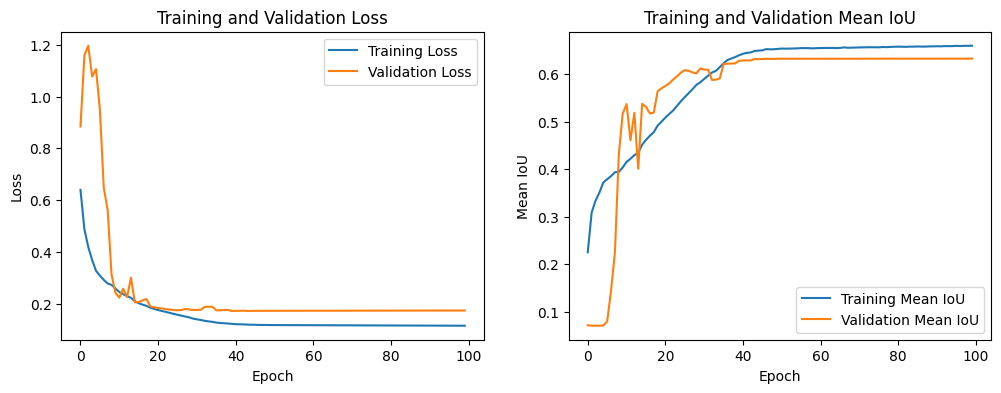

In [122]:
# Visualize Training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_iou'], label='Training Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()

plt.show()

In [123]:
# Evaluate on Validation Set
val_loss, val_miou = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Mean IoU: {val_miou}")

# Make Predictions on Test Set
test_predictions = model.predict(X_test, batch_size=32)
test_predictions = np.argmax(test_predictions, axis=-1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1601 - mean_iou: 0.6444
Validation Loss: 0.1735435575246811
Validation Mean IoU: 0.6323675513267517
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


## Prepare Your Submission

In [124]:
# Save the Model
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241213_165509.keras


In [125]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [126]:
model = tf.keras.models.load_model(
    model_filename,
    custom_objects={
        "CustomMeanIoU": CustomMeanIoU,  
        "loss": weighted_categorical_crossentropy  
    }
)
print(f"Model loaded from {model_filename}")


Model loaded from model_241213_165509.keras


In [127]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Predictions shape: (10022, 64, 128)


In [128]:
import pandas as pd  
import numpy as np   
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [129]:

submission_filename = f"submission_{timestep_str}.csv"
submission_df.to_csv(submission_filename, index=False)


print(f"Submission file saved: {submission_filename}")


Submission file saved: submission_241213_165509.csv
